In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma
import scipy
from scipy.special import gammaln

%matplotlib inline

## Generate Poisson data, compare two Poisson models with different priors

I will generate observed data from a Poisson distribution with a certain lambda. Then I will train a MDN to approximate the posterior over model indices. As models I use a Poisson with Gamma prior and a negative Binomial with Beta prior. 

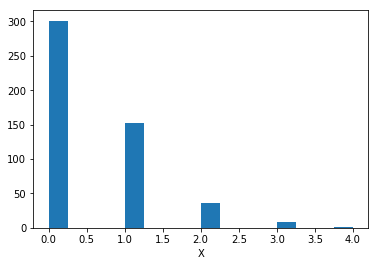

In [2]:
N = 500  # size of toy data
true_lam = .5

# set prior parameters 
shapes = [1., 9.]
scales = [2., .5]


X_o = np.random.poisson(lam=true_lam, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins='auto');
plt.xlabel('X');

## Define functions for generating data from the two different models

In [3]:
def generate_poisson(N, shape, scale): 
    
    # sample from prior
    theta = np.random.gamma(shape, scale)
    # generate samples
    x = np.random.poisson(lam=theta, size=N)
    
    sx = np.mean(x).astype(float)
    
    return theta, sx
    
def generate_dataset(n_samples, sample_size, normalize=True): 
    
    X = []
    thetas = []
    m = []

    # for every sample we want a triplet (m_i, theta, sx)
    for i in range(n_samples): 
        
        # sample model index 
        m_i = np.round(np.random.rand()).astype(int)
    
        # generate data from model 
        # m_i in {0, 1} just sets the index in the array of prior hyperparams
        shape = shapes[m_i]
        scale = scales[m_i]
        theta, sx = generate_poisson(sample_size, shape, scale)
    
        X.append([sx])
        thetas.append([theta])
        m.append([int(m_i)])
    
    X = np.array(X)
    xmean = X.mean(axis=0)
    xstd = X.std(axis=0)    
    if normalize:
        X = (X - xmean) / xstd
    
    return m, np.array(thetas), X, (xmean, xstd)

## Define separate networks for fitting the prior parameter posterior and the model posterior

In [4]:
def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.tanh = nn.Tanh()
        self.scale_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())
        self.shape_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_shape = self.scale_out(act)
        out_scale = self.shape_out(act)
        return (out_shape, out_scale)
    
    
def train(X, Y, model, optim, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_shape, out_scale) = model(x_var)
            loss = mdn_loss_function(out_shape, out_scale, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim

## Define posterior model and corresponding loss function for learning theta

In [5]:
# magical gammaln fun from pyro 
def log_gamma(xx):
    gamma_coeff = [
        76.18009172947146,
        -86.50532032941677,
        24.01409824083091,
        -1.231739572450155,
        0.1208650973866179e-2,
        -0.5395239384953e-5,
    ]
    magic1 = 1.000000000190015
    magic2 = 2.5066282746310005
    x = xx - 1.0
    t = x + 5.5
    t = t - (x + 0.5) * torch.log(t)
    ser = Variable(torch.ones(x.size()) * magic1)
    for c in gamma_coeff:
        x = x + 1.0
        ser = ser + torch.pow(x / c, -1)
    return torch.log(ser * magic2) - t


def gamma_pdf(x, shape, scale, log=False): 
    alpha = shape
    beta = 1 / scale
    
    ll_1 = -beta * x
    ll_2 = (alpha - 1.0) * torch.log(x)
    ll_3 = alpha * torch.log(beta)
    ll_4 = -log_gamma(alpha)
    result = torch.sum(ll_1 + ll_2 + ll_3 + ll_4, -1)
    if log:
        return result
    else: 
        return torch.exp(result)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(out_shape, out_scale, y):
    result = gamma_pdf(y, out_shape, out_scale, log=True)
    result = torch.mean(result)  # mean over batch
    return -result

## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [6]:
# generate data 
m, theta, X, norm = generate_dataset(2000, 10, normalize=False)

In [7]:
# separate it 
mask = np.array(m).squeeze()
theta1, X1, = theta[mask==0], X[mask==0, :]
theta2, X2, = theta[mask==1], X[mask==1, :]

## Train the phi networks for estimating the posteriors over $\mu$

In [8]:
# now train the networks for the two models 
model1 = MDN_phi()
optim1 = torch.optim.Adam(model1.parameters(), lr=0.01)
model1, optim1 = train(X1, theta1, model=model1, optim=optim1, n_epochs=500)

[epoch 0050] loss: 0.2810
[epoch 0100] loss: 0.4085
[epoch 0150] loss: 0.2779
[epoch 0200] loss: 0.3987
[epoch 0250] loss: 0.3354
[epoch 0300] loss: 0.5201
[epoch 0350] loss: 0.3177
[epoch 0400] loss: 0.2566
[epoch 0450] loss: 0.2362
[epoch 0500] loss: 0.3093


In [9]:
model2 = MDN_phi()
optim2 = torch.optim.Adam(model2.parameters(), lr=0.01)
model2, optim2 = train(X2, theta2, model=model2, optim=optim2, n_epochs=500)

[epoch 0050] loss: 1.1678
[epoch 0100] loss: 1.1214
[epoch 0150] loss: 0.8632
[epoch 0200] loss: 0.9546
[epoch 0250] loss: 0.9392
[epoch 0300] loss: 1.0303
[epoch 0350] loss: 0.9011
[epoch 0400] loss: 0.9900
[epoch 0450] loss: 0.9622
[epoch 0500] loss: 0.8788


In [10]:
def get_posterior(model, X_o, thetas): 
    data = np.mean(X_o) # (np.sum(X_o) - norm[0]) / norm[1]
    
    stats_o = np.array(data.astype(float)).reshape(1, 1)

    X_var = Variable(torch.Tensor(stats_o))

    (out_shape, out_scale) = model(X_var)

    # make sure all variabel have dimensions (N, 1)
    out_shapes = Variable(torch.Tensor(out_shape.data * torch.ones(thetas.size))).view(N, 1)
    out_scales = Variable(torch.Tensor(out_scale.data * torch.ones(thetas.size))).view(N, 1)

    post = gamma_pdf(Variable(torch.Tensor(thetas.reshape(N, 1))), out_shapes, out_scales, log=False).data.numpy()
    return post

In [11]:
thetas = np.linspace(0, 10, N)
post1 = get_posterior(model1, X_o, thetas)
post2 = get_posterior(model2, X_o, thetas)

In [12]:
prior1 = gamma.pdf(x=thetas, a=shapes[0], loc=0, scale=scales[0])
prior2 = gamma.pdf(x=thetas, a=shapes[1], loc=0, scale=scales[1])

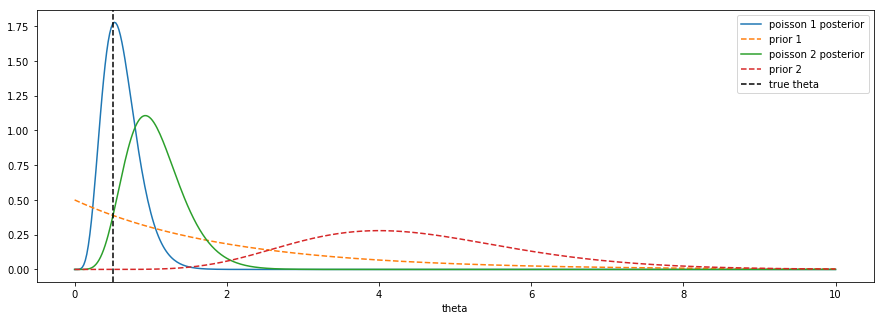

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(thetas, post1.squeeze(), label='poisson 1 posterior')
plt.plot(thetas, prior1, '--', label='prior 1')

plt.plot(thetas, post2.squeeze(), label='poisson 2 posterior')
plt.plot(thetas, prior2, '--', label='prior 2')

plt.axvline(x=true_lam, label='true theta', linestyle='--', color='k')
plt.xlabel('theta')
plt.legend();

## Now train the model posterior

In [14]:
class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=1, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = nn.Linear(n_hidden, ndim_output)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m

lossfun = nn.CrossEntropyLoss()

def psi_loss_function(m, out): 
    M = m.size
    J = Variable(torch.Tensor([0]))

    for i in range(M):
        J += torch.log(out[i, m[i]])
        
    result = J / M
    
    return - result

def train_psi(X, Y, model, optim, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]
    
    losses = []

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))            
            y_var = Variable(torch.LongTensor(y_batch)).view(n_minibatch)
            
            (out_act) = model(x_var)
            loss = lossfun(out_act, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data[0])

        if (epoch + 1) % 100 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim, losses

def poisson_evidence(x, a, b, N, log=False): 
    x_sum = np.sum(x)
    log_xfac = np.sum(gammaln(x + 1))
    
    result = a * np.log(b) - gammaln(a) - log_xfac + gammaln(a + x_sum) - (a + x_sum)*np.log(b + N)
    
    return result if log else np.exp(result)

In [15]:
model = MDN_psi(n_hidden=10)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

model_psi, optim_psi, losses = train_psi(X, m, model, optim, n_epochs=1000, n_minibatch=100)

[epoch 0100] loss: 0.6378
[epoch 0200] loss: 0.5158
[epoch 0300] loss: 0.4549
[epoch 0400] loss: 0.4460
[epoch 0500] loss: 0.4094
[epoch 0600] loss: 0.4613
[epoch 0700] loss: 0.4071
[epoch 0800] loss: 0.5075
[epoch 0900] loss: 0.4123
[epoch 1000] loss: 0.3715


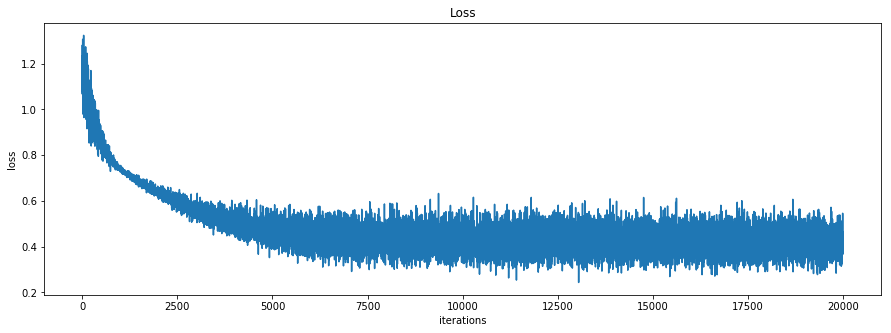

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss');

## Draw many samples and compare predicted to analytical Bayes Factor

In [20]:
bf_true = []
bf_predicted = []

for i in range(100): 
    
    # draw samples 
    samples = np.random.poisson(true_lam, N)
    
    # apply model for prediction
    stats_o = np.array(np.mean(samples).astype(float)).reshape(1, 1)
    X_var = Variable(torch.Tensor(stats_o))
    (out_act) = model(X_var)
    
    # calculate bf 
    m = nn.Softmax()
    posterior_probs = m(out_act).data.numpy()
    bf_predicted.append(posterior_probs[0][0] / posterior_probs[0][1])
    
    # because we use a uniform prior the posterior ratio corresponds to the likelihood (evidence) ratio
    e1 = poisson_evidence(samples, shapes[0], scales[0], N, log=True)
    e2 = poisson_evidence(samples, shapes[1], scales[1], N, log=True)
    bf_true.append(np.exp(e1 - e2))

In [21]:
bf1 = (bf_true - np.mean(bf_true))/np.std(bf_true)
bf2 = (bf_predicted - np.mean(bf_predicted))/np.std(bf_predicted)

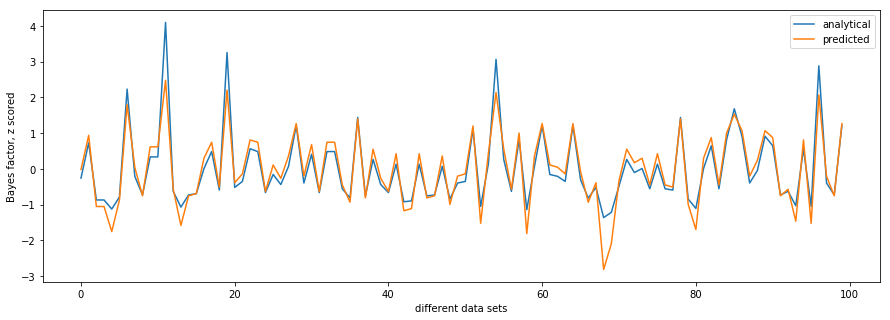

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(bf1, label='analytical')
plt.plot(bf2, label='predicted')
plt.xlabel('different data sets')
plt.ylabel('Bayes factor, z scored')
plt.legend();